In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

from utils import *
from train import *
from conv import *

### Loading Fashion MNIST data

In [2]:
BATCH_SIZE=64

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
train_dataloader, test_dataloader, class_names = dataloader(train_dataset, test_dataset, BATCH_SIZE)

In [5]:
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001C3D2B1EE50>, <torch.utils.data.dataloader.DataLoader object at 0x000001C3D2B1E4C0>)
Length of train dataloader: 938 batches of 64
Length of test dataloader: 157 batches of 64


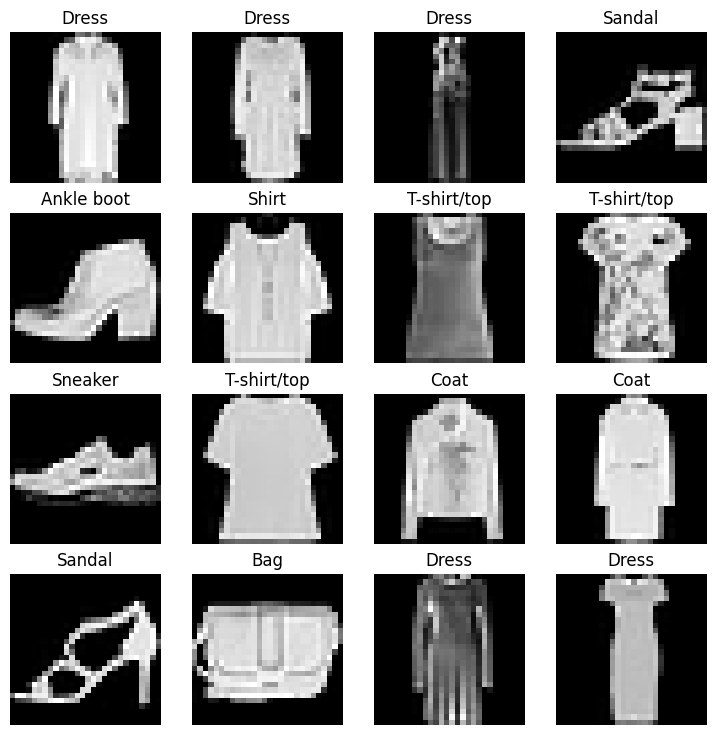

In [6]:
show_images(train_dataset, class_names, 4, 4)

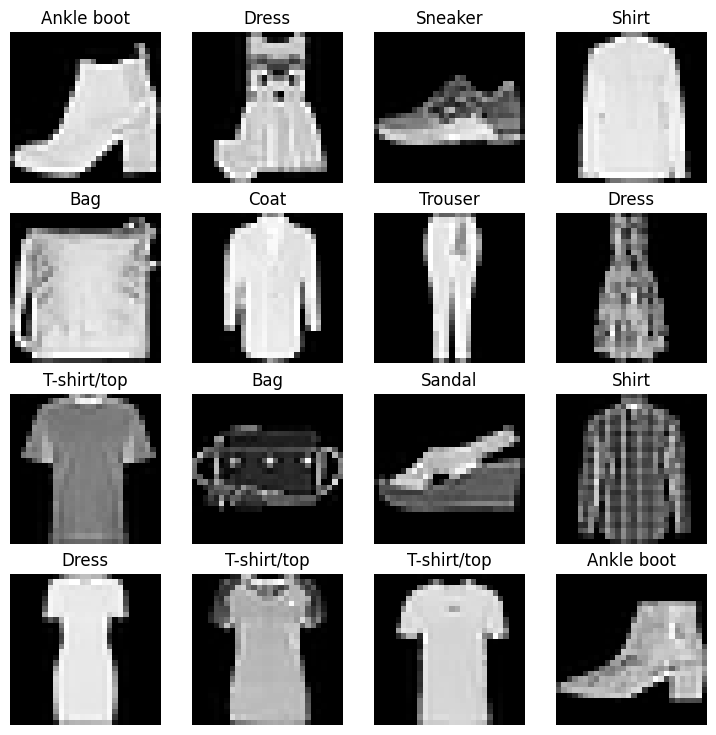

In [7]:
show_images(test_dataset, class_names, 4, 4)

In [8]:
# from torch.utils.data import default_collate

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 16),
    conv(16, 10, act=False),
    nn.Flatten()
)

In [11]:
lr = 0.4

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn.parameters(), lr=lr)

train_loss, train_acc, test_loss, test_acc = fit(5, cnn, train_dataloader, test_dataloader, loss_fn, optimizer, device)

 20%|██        | 1/5 [00:09<00:36,  9.14s/it]

| Epoch: 0 | Train loss: 0.7709878087043762 | Train accuracy: 0.7125699626865671 | Test loss: 0.6271665692329407 | Test accuracy: 0.7916003184713376 |


 40%|████      | 2/5 [00:15<00:23,  7.71s/it]

| Epoch: 1 | Train loss: 0.6079340577125549 | Train accuracy: 0.7738123001066098 | Test loss: 0.5757836103439331 | Test accuracy: 0.8026472929936306 |


 60%|██████    | 3/5 [00:22<00:14,  7.25s/it]

| Epoch: 2 | Train loss: 0.5376488566398621 | Train accuracy: 0.7996957178393745 | Test loss: 0.5746445059776306 | Test accuracy: 0.7960456475583864 |


 80%|████████  | 4/5 [00:29<00:07,  7.10s/it]

| Epoch: 3 | Train loss: 0.4971623718738556 | Train accuracy: 0.8149486940298507 | Test loss: 0.5327137112617493 | Test accuracy: 0.8085688694267515 |


100%|██████████| 5/5 [00:36<00:00,  7.22s/it]

| Epoch: 4 | Train loss: 0.4696451723575592 | Train accuracy: 0.8251932302771855 | Test loss: 0.502625584602356 | Test accuracy: 0.8177945859872612 |


In [12]:
train_loss, train_acc, test_loss, test_acc 

(0.46964519964352347,
 0.8251932302771855,
 0.5026255613679339,
 0.8177945859872612)